# Using XGBoost to Forecast NSW Energy Demand
This notebook will be used for developing an XGBoost model that will be used for forecasting the demand in NSW, with the particular goal of looking at how residential (small scale) solar PV impacts the daily maximum, minimum and range of demand in NSW.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import multiprocessing

In [2]:
# set style for plots
sns.set_theme()

In [3]:
# read in data
df = pd.read_csv('../data/raw/all_data.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df.sort_index()
df.drop(['temp_mean', 'units', 'cum_units', 'output'], axis=1, inplace=True)

In [4]:
def create_date_predictors(dataframe):
    df = dataframe.copy()
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    return df

In [5]:
# Add in datetime predictors
df = create_date_predictors(df)

In [6]:
df

,demand_min,demand_max,temp_min,temp_max,cum_output,population,dayofweek,month,year,dayofyear,dayofmonth
datetime,,,,,,,,,,,
2010-01-01,6157.36,8922.42,22.1,28.8,3.036293e+04,7.144292e+06,4,1,2010,1,1
2010-01-02,6112.73,9326.64,21.6,29.4,3.049634e+04,7.144495e+06,5,1,2010,2,2
2010-01-03,6014.91,8277.85,17.9,21.5,3.062975e+04,7.144699e+06,6,1,2010,3,3
2010-01-04,6023.79,9522.30,17.9,23.9,3.076316e+04,7.144902e+06,0,1,2010,4,4
2010-01-05,6287.12,10728.72,15.4,27.7,3.089657e+04,7.145106e+06,1,1,2010,5,5
...,...,...,...,...,...,...,...,...,...,...,...
2020-11-26,6051.38,10871.75,14.8,32.5,3.490182e+06,8.093864e+06,3,11,2020,331,26
2020-11-27,6152.19,10173.41,18.6,26.3,3.493903e+06,8.093863e+06,4,11,2020,332,27
2020-11-28,6284.18,12421.83,18.3,40.4,3.497624e+06,8.093862e+06,5,11,2020,333,28


In [7]:
# set up data for model
y_min = df['demand_min']
y_max = df['demand_max']
X = df.drop(['demand_max', 'demand_min'], axis=1)

In [8]:
# set up model use grid search CV for starting place
search_params = {'max_depth': [ 4, 5, 6, 8], 'n_estimators':[4000], 'learning_rate': [0.01, 0.05]}
# Create 5, 1 year splits
splits = TimeSeriesSplit(n_splits=5, test_size=365)

xgb_model = xgb.XGBRegressor(n_jobs=multiprocessing.cpu_count()//2,
                             objective='reg:squarederror',
                             early_stopping_rounds=50,
                             booster='gbtree')
grid_reg_max = GridSearchCV(estimator=xgb_model,
                            param_grid=search_params,
                            cv=splits.split(X, y_max),
                            n_jobs=2,
                            verbose=1)
grid_reg_max.fit(X, y_max, eval_set=[(X, y_max)], verbose=100)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[0]	validation_0-rmse:9681.45235
[100]	validation_0-rmse:3598.79360
[200]	validation_0-rmse:1383.13854
[300]	validation_0-rmse:605.52467
[400]	validation_0-rmse:363.80998
[500]	validation_0-rmse:297.11364
[600]	validation_0-rmse:272.82468
[700]	validation_0-rmse:257.43664
[800]	validation_0-rmse:248.03136
[900]	validation_0-rmse:240.37645
[1000]	validation_0-rmse:233.43794
[1100]	validation_0-rmse:227.87622
[1200]	validation_0-rmse:223.16476
[1300]	validation_0-rmse:216.54720
[1400]	validation_0-rmse:210.46812
[1500]	validation_0-rmse:205.36162
[1600]	validation_0-rmse:199.46383
[1700]	validation_0-rmse:194.62451
[1800]	validation_0-rmse:190.84703
[1900]	validation_0-rmse:186.80737
[2000]	validation_0-rmse:182.25548
[2100]	validation_0-rmse:177.93800
[2200]	validation_0-rmse:173.82482
[2300]	validation_0-rmse:170.81081
[2400]	validation_0-rmse:166.70520
[2500]	validation_0-rmse:162.23357
[2600]	validation_0-rmse:158.65332
[270

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x000002482960CAC0>,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=50,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_...
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=8, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=2,
             param_grid={'learning_rate': [0.01, 0.05],
                         'max_depth': [4, 5, 6, 8], 'n_estimators': [4000]},
             verbose=1)

In [9]:
print(grid_reg_max.best_params_)
print(grid_reg_max.best_score_)
print(np.sqrt(mean_squared_error(y_max, grid_reg_max.predict(X))))

{'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 4000}
0.8622736363776624
115.80628557528611


Seems like an okay starting place. Learning rate may be too high and may be trying to over fit.
Let's try another round of CV with early stopping and try to pin down good hyperparameters.

# Create Model for Predicting Maximums

In [10]:
def cv_test_xgb(x_df, y_df, num_est, depth, lr, early_stop):
    """
    Function for Time Series Cross Validation of an XGB Regressor Model
    """
    preds = []
    scores = []
    num_est_used = []

    tss = TimeSeriesSplit(n_splits=5, test_size=365)

    for train_idx, val_idx in tss.split(x_df):
        X_train = x_df.iloc[train_idx]
        X_test = x_df.iloc[val_idx]

        y_train = y_df.iloc[train_idx]
        y_test = y_df.iloc[val_idx]

        reg = xgb.XGBRegressor(base_score=0.5,
                               n_jobs=multiprocessing.cpu_count()//2,
                               booster='gbtree',
                               n_estimators=num_est,
                               early_stopping_rounds=early_stop,
                               objective='reg:squarederror',
                               max_depth=depth,
                               learning_rate=lr)
        reg.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                verbose=100)

        y_pred = reg.predict(X_test)
        preds.append(y_pred)
        score = np.sqrt(mean_squared_error(y_test, y_pred))
        scores.append(score)
        num_est_used.append(reg.best_iteration)

    print(f'Mean score: {np.mean(scores):0.3f}')
    print(f'Scores on each fold: {scores} \n')
    print(f'Mean number of estimators used: {np.mean(num_est_used):0.0f}')
    print(f'Number of estimators used in each fold: {num_est_used}')



In [11]:
# The parameters here were tweaked to find a good combination, bringing in findings from the prior GridSearchCV
cv_test_xgb(X, y_max, 3000, 6, 0.01, 75)

[0]	validation_0-rmse:9779.00244	validation_1-rmse:9476.48179
[100]	validation_0-rmse:3642.78965	validation_1-rmse:3534.20570
[200]	validation_0-rmse:1399.90066	validation_1-rmse:1435.23002
[300]	validation_0-rmse:600.10171	validation_1-rmse:743.89225
[400]	validation_0-rmse:341.88043	validation_1-rmse:551.38622
[500]	validation_0-rmse:263.51991	validation_1-rmse:500.79065
[600]	validation_0-rmse:233.55323	validation_1-rmse:485.16438
[700]	validation_0-rmse:218.70902	validation_1-rmse:478.22539
[800]	validation_0-rmse:206.03888	validation_1-rmse:470.39703
[900]	validation_0-rmse:196.67316	validation_1-rmse:467.52738
[1000]	validation_0-rmse:187.78366	validation_1-rmse:467.59128
[1100]	validation_0-rmse:178.75776	validation_1-rmse:464.76546
[1200]	validation_0-rmse:170.92391	validation_1-rmse:463.66323
[1300]	validation_0-rmse:162.67944	validation_1-rmse:461.06042
[1400]	validation_0-rmse:155.64816	validation_1-rmse:460.20663
[1500]	validation_0-rmse:148.80290	validation_1-rmse:459.5645

In [12]:
# Re-train using findings on larger dataset, reserve some  data to compare model to Linear Regression Models from earlier
model_mask = (df.index >= '2010-01-01') & (df.index < '2019-01-01')
val_mask = (df.index >= '2019-01-01') & (df.index < '2020-12-01')

model_df = df[model_mask]
val_df = df[val_mask]

In [13]:
y_min_model = model_df['demand_min']
y_max_model = model_df['demand_max']
X_model = model_df.drop(['demand_max', 'demand_min'], axis=1)

y_min_val = val_df['demand_min']
y_max_val = val_df['demand_max']
X_val = val_df.drop(['demand_max', 'demand_min'], axis=1)

In [14]:
reg_max = xgb.XGBRegressor(base_score=0.5,
                           n_jobs=multiprocessing.cpu_count()//2,
                           booster='gbtree',
                           n_estimators=1000,
                           objective='reg:squarederror',
                           max_depth=6,
                           learning_rate=0.01)
reg_max.fit(X_model, y_max_model,
            eval_set=[(X_model, y_max_model)],
            verbose=100)

[0]	validation_0-rmse:9702.29584
[100]	validation_0-rmse:3608.61905
[200]	validation_0-rmse:1387.40891
[300]	validation_0-rmse:604.63369
[400]	validation_0-rmse:359.51272
[500]	validation_0-rmse:291.46462
[600]	validation_0-rmse:265.27405
[700]	validation_0-rmse:249.67303
[800]	validation_0-rmse:237.41609
[900]	validation_0-rmse:226.17443
[999]	validation_0-rmse:217.55319


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=8, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [15]:
# Look at the error on the reserved set for comparison to the linear model
np.sqrt(mean_squared_error(y_max_val, reg_max.predict(X_val)))

444.78094746973017

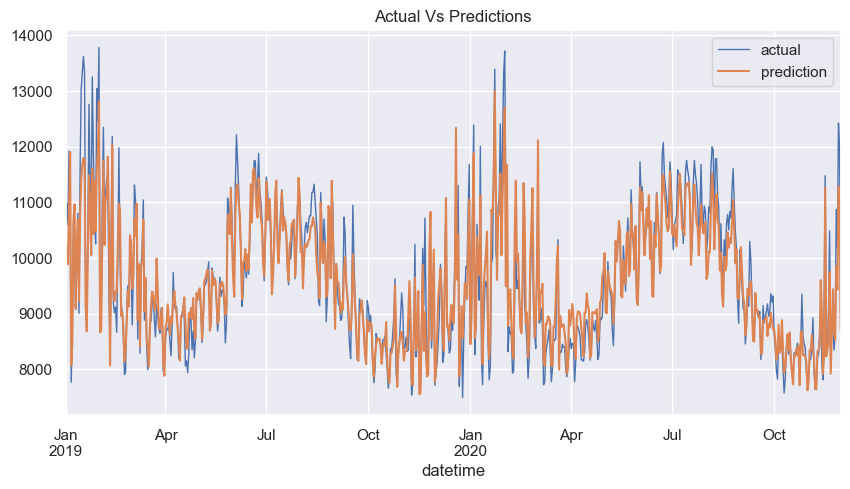

In [16]:
ax = y_max_val.plot(figsize=(10, 5), ms=1, lw=1, title='Actual Vs Predictions')
pd.DataFrame({'Predictions':reg_max.predict(X_val)}, index=y_max_val.index).plot(ax=ax)
plt.legend(['actual', 'prediction'])
plt.show()

# Create Model for Predicting Minimums
Now let's build a model for predicting minimums. We will use the GridSearchCV findings from earlier as a starting place.

In [17]:
# Parameters were again tweaked to find a good model
cv_test_xgb(X, y_min, 3000, 4, 0.01, 75)

[0]	validation_0-rmse:6215.70808	validation_1-rmse:6026.76093
[100]	validation_0-rmse:2293.90095	validation_1-rmse:2239.90214
[200]	validation_0-rmse:863.29318	validation_1-rmse:870.32944
[300]	validation_0-rmse:352.02231	validation_1-rmse:394.04771
[400]	validation_0-rmse:188.04644	validation_1-rmse:244.31647
[500]	validation_0-rmse:144.23100	validation_1-rmse:205.79175
[600]	validation_0-rmse:132.02270	validation_1-rmse:195.38863
[700]	validation_0-rmse:126.33193	validation_1-rmse:192.25134
[800]	validation_0-rmse:122.68832	validation_1-rmse:191.93035
[827]	validation_0-rmse:121.91193	validation_1-rmse:191.98578
[0]	validation_0-rmse:6188.69685	validation_1-rmse:6175.22392
[100]	validation_0-rmse:2283.91966	validation_1-rmse:2375.88315
[200]	validation_0-rmse:860.04087	validation_1-rmse:991.65108
[300]	validation_0-rmse:353.10360	validation_1-rmse:501.15933
[400]	validation_0-rmse:193.22367	validation_1-rmse:327.66425
[500]	validation_0-rmse:150.69578	validation_1-rmse:264.53609
[600

In [18]:
reg_min = xgb.XGBRegressor(base_score=0.5,
                           n_jobs=multiprocessing.cpu_count()//2,
                           booster='gbtree',
                           n_estimators=1000,
                           objective='reg:squarederror',
                           max_depth=4,
                           learning_rate=0.01)
reg_min.fit(X_model, y_min_model,
            eval_set=[(X_model, y_min_model)],
            verbose=100)

[0]	validation_0-rmse:6187.66626
[100]	validation_0-rmse:2283.65645
[200]	validation_0-rmse:861.78696
[300]	validation_0-rmse:358.79969
[400]	validation_0-rmse:202.40397
[500]	validation_0-rmse:160.28200
[600]	validation_0-rmse:146.64773
[700]	validation_0-rmse:140.07533
[800]	validation_0-rmse:135.61962
[900]	validation_0-rmse:131.83401
[999]	validation_0-rmse:128.40110


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=8, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [19]:
# Look at the error on the reserved set for comparison to the linear model
np.sqrt(mean_squared_error(y_min_val, reg_min.predict(X_val)))

223.4929012539864

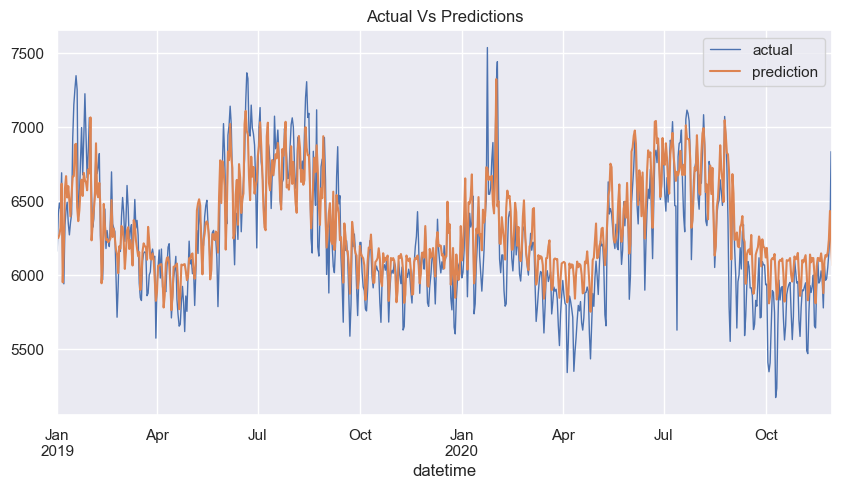

In [20]:
ax = y_min_val.plot(figsize=(10, 5), ms=1, lw=1, title='Actual Vs Predictions')
pd.DataFrame({'Predictions':reg_min.predict(X_val)}, index=y_min_val.index).plot(ax=ax)
plt.legend(['actual', 'prediction'])
plt.show()

We can se a large improvement compared to the linear models, RMSE is about half what it was for the LM models for both min and max.

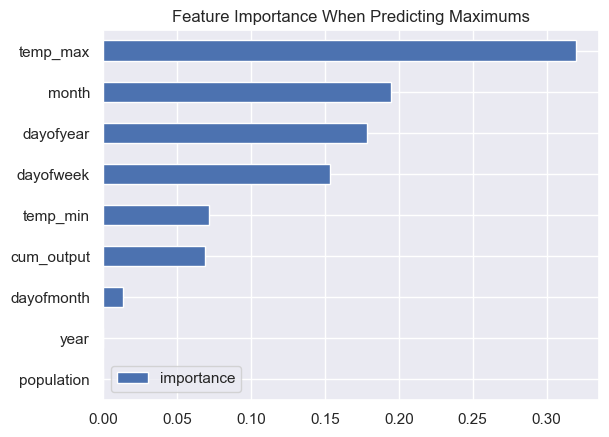

In [21]:
fi_max = pd.DataFrame(data=reg_max.feature_importances_,
                      index=reg_max.feature_names_in_,
                      columns=['importance'])
fi_max.sort_values('importance').plot(kind='barh', title='Feature Importance When Predicting Maximums')
plt.show()

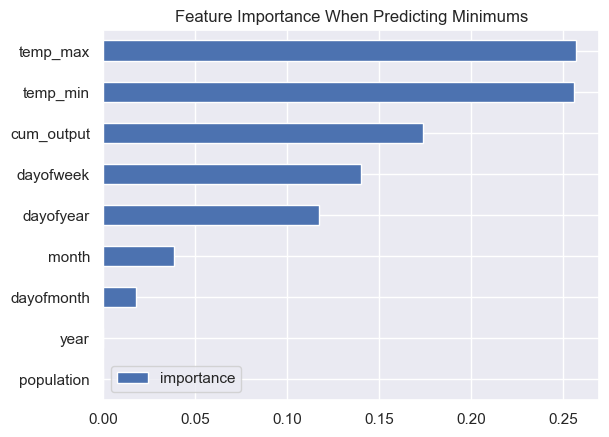

In [22]:
fi_min = pd.DataFrame(data=reg_min.feature_importances_,
                      index=reg_min.feature_names_in_,
                      columns=['importance'])
fi_min.sort_values('importance').plot(kind='barh', title='Feature Importance When Predicting Minimums')
plt.show()

# Use model to look at Future
Import data from forecasted future predictions and use model to look at trends in min/max

In [24]:
# Create final max predicting model using all available data
reg_max_final = xgb.XGBRegressor(base_score=0.5,
                                 n_jobs=multiprocessing.cpu_count()//2,
                                 booster='gbtree',
                                 n_estimators=1100,
                                 objective='reg:squarederror',
                                 max_depth=6,
                                 learning_rate=0.01)
reg_max_final.fit(X, y_max,
                  eval_set=[(X, y_max)],
                  verbose=100)

[0]	validation_0-rmse:9681.45235
[100]	validation_0-rmse:3598.79360
[200]	validation_0-rmse:1383.13854
[300]	validation_0-rmse:605.52467
[400]	validation_0-rmse:363.80998
[500]	validation_0-rmse:297.11364
[600]	validation_0-rmse:272.82468
[700]	validation_0-rmse:257.43664
[800]	validation_0-rmse:248.03136
[900]	validation_0-rmse:240.37645
[1000]	validation_0-rmse:233.43794
[1099]	validation_0-rmse:227.93417


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1100, n_jobs=8, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [31]:
# Create final min predicting model using all available data
reg_min_final = xgb.XGBRegressor(base_score=0.5,
                                 n_jobs=multiprocessing.cpu_count()//2,
                                 booster='gbtree',
                                 n_estimators=1100,
                                 objective='reg:squarederror',
                                 max_depth=4,
                                 learning_rate=0.01)
reg_min_final.fit(X, y_min,
                  eval_set=[(X, y_min)],
                  verbose=100)

[0]	validation_0-rmse:6189.21351
[100]	validation_0-rmse:2283.87658
[200]	validation_0-rmse:862.11909
[300]	validation_0-rmse:360.73387
[400]	validation_0-rmse:205.32035
[500]	validation_0-rmse:164.41599
[600]	validation_0-rmse:150.81620
[700]	validation_0-rmse:144.03476
[800]	validation_0-rmse:139.88154
[900]	validation_0-rmse:136.67035
[1000]	validation_0-rmse:133.79485
[1099]	validation_0-rmse:131.12934


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1100, n_jobs=8, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [26]:
df_future = pd.read_csv('../data/raw/future_projections.csv')
df_future['datetime'] = pd.to_datetime(df_future['datetime'])
df_future.set_index('datetime', inplace=True)
df_future.sort_index()
df_future = create_date_predictors(df_future)
df_future = df_future[['temp_min', 'temp_max', 'cum_output', 'population', 'dayofweek', 'month', 'year', 'dayofyear', 'dayofmonth']]
df_future

,temp_min,temp_max,cum_output,population,dayofweek,month,year,dayofyear,dayofmonth
datetime,,,,,,,,,
2021-01-01,18.8,26.0,3.626240e+06,8.154720e+06,4,1,2021,1,1
2021-01-02,18.8,26.0,3.630094e+06,8.154885e+06,5,1,2021,2,2
2021-01-03,18.8,26.0,3.633951e+06,8.155051e+06,6,1,2021,3,3
2021-01-04,18.8,26.0,3.637813e+06,8.155216e+06,0,1,2021,4,4
2021-01-05,18.8,26.0,3.641679e+06,8.155382e+06,1,1,2021,5,5
...,...,...,...,...,...,...,...,...,...
2026-12-27,17.6,25.2,3.696424e+07,8.524987e+06,6,12,2026,361,27
2026-12-28,17.6,25.2,3.700352e+07,8.525160e+06,0,12,2026,362,28
2026-12-29,17.6,25.2,3.704284e+07,8.525333e+06,1,12,2026,363,29


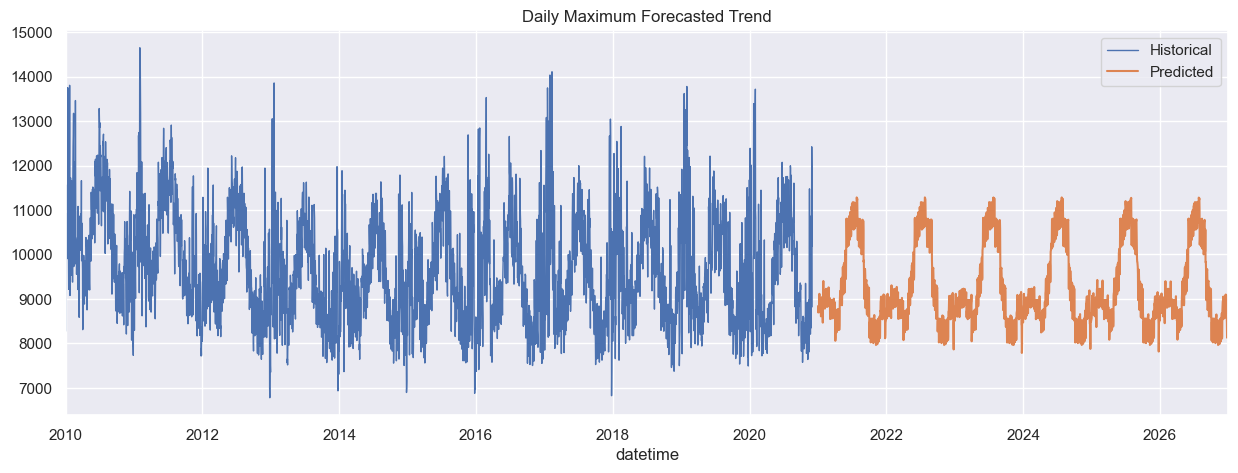

In [29]:
ax = df['demand_max'].plot(figsize=(15, 5), ms=1, lw=1, title='Daily Maximum Forecasted Trend')
pd.DataFrame({'Predictions':reg_max_final.predict(df_future)}, index=df_future.index).plot(ax=ax)
plt.legend(['Historical', 'Predicted'])
plt.show()

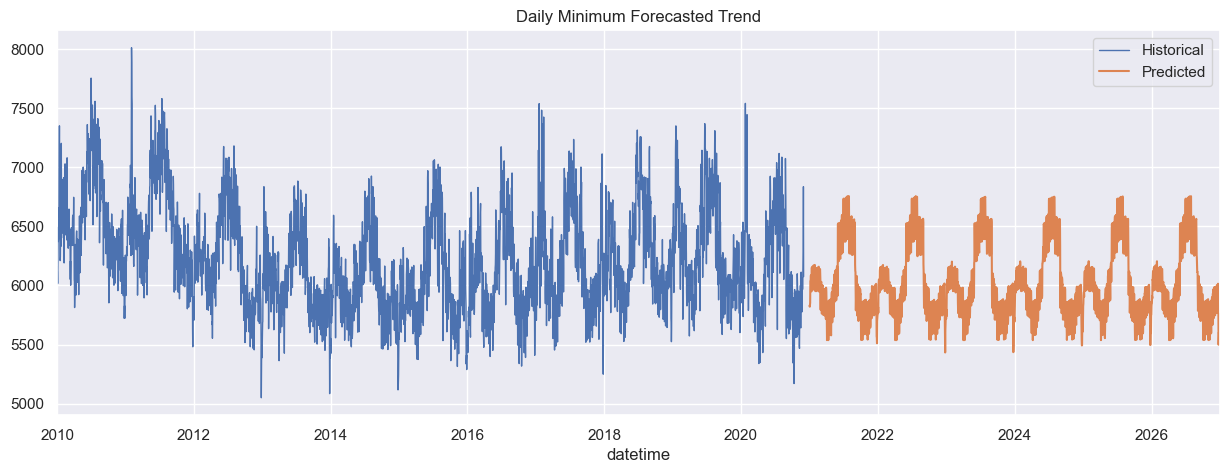

In [30]:
ax = df['demand_min'].plot(figsize=(15, 5), ms=1, lw=1, title='Daily Minimum Forecasted Trend')
pd.DataFrame({'Predictions':reg_min_final.predict(df_future)}, index=df_future.index).plot(ax=ax)
plt.legend(['Historical', 'Predicted'])
plt.show()